## **O4_Modelling**

In dieser Datei werden die aufbereiteten Daten auf die Machine Learning Modelle Random Forest, XGBoost und ... angewendet. 
Für die Evaluation ...
Die Explainable Artifical Intelligence (XAI)-Methoden SHARP und PFI werden auf die Ergebnsise angewendet.
Cross Validation/Hyperparameter ....

In [1]:
# Imports
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Pipeline und Model-Transformationen
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

# Modelle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# XAI
import shap
from sklearn.inspection import permutation_importance


# Load Functions
from functions import *


/Users/juliaschmid/.pyenv/versions/3.11.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_data()

df.head()

,district,style,extwall,stories,year_built,units,bdrms,fbath,hbath,lotsize,sale_price
0,1,Cape Cod,Aluminum_Vinyl,1.5,1959,1,4,2,0,7000,129000
1,1,Cape Cod,Brick,1.0,1951,1,3,2,1,8100,67000
2,1,Cape Cod,Brick,1.5,1938,1,3,1,1,5040,103000
3,1,Cape Cod,Aluminum_Vinyl,1.5,1960,1,4,2,0,6000,150000
4,1,Cape Cod,Aluminum_Vinyl,1.0,1954,1,4,2,1,4920,89900


In [3]:
# Bestimmung der numerischen und kategorischen Variablen 
numericalVar = [col for col in df if df[col].dtype != 'object']
numericalVar.remove("sale_price") 
categoricalVar = [col for col in df if df[col].dtype == 'object']

In [4]:
#X = df.drop(columns=['sale_price'])
#y = df['sale_price']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

y = "sale_price"
X = df.columns.to_list()
X.remove(y)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=123)

In [5]:
# Transformationen (Pipeline)

# Numerische Variablen
numericalPipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), # Anpassen? /IterativeImputer
    ("scaler", QuantileTransformer(output_distribution="normal"))
])

# Kategorische Variablen
categoricalPipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

# Transformationen-CT
transformationCT = ColumnTransformer(
    transformers=[
        ('num', numericalPipe, numericalVar),
        ('cat', categoricalPipe, categoricalVar)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [6]:
# Modelle definieren
model_lr = LinearRegression()
model_rf = RandomForestRegressor()
model_gb = GradientBoostingRegressor()

In [7]:
# Model Pipelines 

# Lineare Regression
LR_Pipe = Pipeline(steps=[
    ("preprocess", transformationCT),
    ("model", model_lr)
])

# Random Forest
RF_Pipe = Pipeline(steps=[
    ("preprocess", transformationCT),
    ("model", model_rf)
])

# Gradient Boosting
GB_Pipe = Pipeline(steps=[
    ("preprocess", transformationCT),
    ("model", model_gb)
])


In [8]:
# Training der Modelle 
LR_Pipe.fit(train_data[X], train_data[y])
RF_Pipe.fit(train_data[X], train_data[y])
GB_Pipe.fit(train_data[X], train_data[y])

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [9]:
# Vorhersage der Modelle 
y_pred_lr = LR_Pipe.predict(test_data[X])
y_pred_rf = RF_Pipe.predict(test_data[X])
y_pred_gb = GB_Pipe.predict(test_data[X])


### Evaluation

**Evaluationsmetriken**

In [10]:
df_result = pd.concat([
   calculate_metrics(test_data[y], y_pred_lr, "LineareRegression"),
   calculate_metrics(test_data[y], y_pred_rf, "RandomForest"),
   calculate_metrics(test_data[y], y_pred_gb, "GradientBoosting"),
], ignore_index=True)

df_result

LineareRegression
MAE: 852174.831
MSE: 1142470465021.524
RMSE: 1068864.1
R²: 0.146
-------------------------
RandomForest
MAE: 842013.397
MSE: 1218399420102.631
RMSE: 1103811.315
R²: 0.089
-------------------------
GradientBoosting
MAE: 832854.365
MSE: 1085609050443.648
RMSE: 1041925.645
R²: 0.188
-------------------------


,Model,MAE,MSE,RMSE,R²
0,LineareRegression,852174.831,1.142470e+12,1068864.100,0.146
1,RandomForest,842013.397,1.218399e+12,1103811.315,0.089
2,GradientBoosting,832854.365,1.085609e+12,1041925.645,0.188


**Predicted VS Actual**

In [11]:
generate_predictedVSactualPlot(y_pred_lr, test_data[y], "LineareRegression")
generate_predictedVSactualPlot(y_pred_rf, test_data[y], "RandomForest")
generate_predictedVSactualPlot(y_pred_gb, test_data[y], "GradientBoosting")

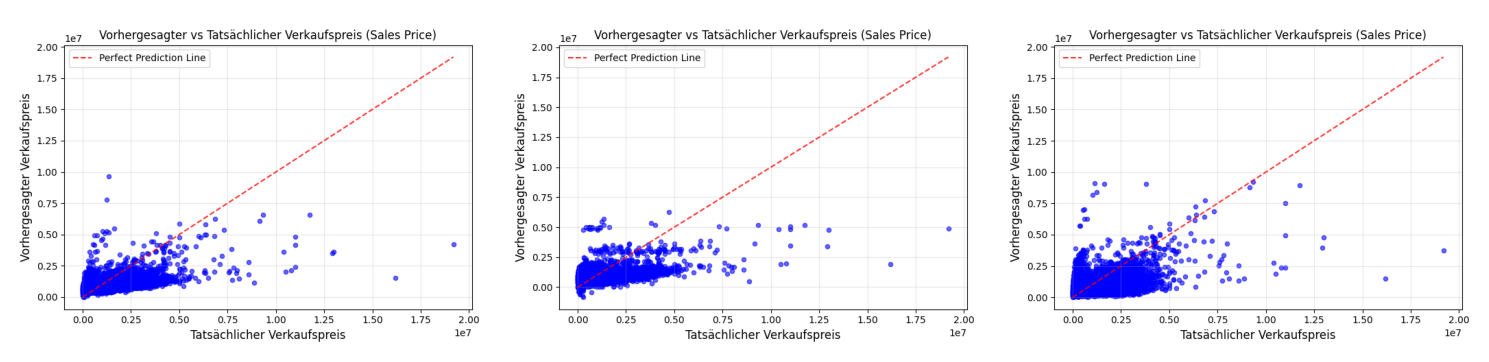

In [12]:
ordner = "../output/"
list_pictures = [datei for datei in os.listdir(ordner) if datei.startswith("sales_price_predictionVsactual_")]
list_pictures = [ordner + n for n in list_pictures]
list_pictures

# Plot mit 1 Zeile und 3 Spalten
fig, axs = plt.subplots(1, len(list_pictures), figsize=(15, 5))  # figsize anpassen

for i, datei in enumerate(list_pictures):
    img = mpimg.imread(datei)
    axs[i].imshow(img)
    axs[i].axis("off")  # Achsen ausblenden

plt.tight_layout()
plt.show()

**Cross Validation**

In [13]:
# df_CV = pd.concat([
#     calculate_crossValidation(LR_Pipe,train_data[X],train_data[y], "LineareRegression"),
#     calculate_crossValidation(RF_Pipe,train_data[X],train_data[y], "RandomForest"),
#     calculate_crossValidation(GB_Pipe,train_data[X],train_data[y], "GradientBoosting"),
# ], ignore_index=True)
# df_CV

**Hyperparametertuning**

In [14]:
from sklearn.model_selection import ParameterGrid

parameters_lr = {'alpha': [0.1, 1, 10, 100]}
print(len(list(ParameterGrid(parameters_lr))))

parameters_rf = {
    "model__n_estimators": [100, 200],
    #"model__max_depth": [None, 5, 10, 20, 50],
    "model__min_samples_split": [2, 5],
    #"model__min_samples_leaf": [1, 2, 4, 10],
    "model__max_features": ["auto", "sqrt", "log2"]
}
print(len(list(ParameterGrid(parameters_rf))))

parameters_gb = {
    "model__n_estimators": [100, 1000],
    "model__learning_rate": [0.01, 0.2],
    #"model__max_depth": [3, 5, 10],
    #"model__min_samples_split": [2, 5],
    #"model__min_samples_leaf": [1, 2, 4],
    "model__subsample": [0.1, 0.6],
    "model__max_features": ["auto", "sqrt"]
}
print(len(list(ParameterGrid(parameters_gb))))

4
12
16


In [15]:
# from sklearn.model_selection import GridSearchCV

# cv_folds = 3
# grid_search_dt = GridSearchCV(estimator=LR_Pipe, param_grid=parameters_lr, cv=cv_folds, n_jobs=5)
# grid_search_dt.fit(train_data[X], train_data[y])

# print("Beste Parameter:", grid_search_dt.best_params_)
# print("Bester CV-Score:", grid_search_dt.best_score_)
# print("Test-Score:", grid_search_dt.score(test_data[X], test_data[y]))

# best_model_dt = grid_search_dt.best_estimator_

# y_pred_dt = best_model_dt.predict(test_data[X])
# df_result = calculate_metrics(test_data[y], y_pred_dt, "DecisionTree HT")

In [16]:
#best_model_dt = conduct_gridSearch(DT_Pipe,parameters_dt, X_train,y_train, X_test, y_test, "DecisionTree HT")
#y_pred_dt = best_model_dt.predict(X_test)
#df_result = calculate_metrics(y_test, y_pred_dt, "DecisionTree HT")

### XAI Methoden

**SHAP**

In [17]:
calculate_shap(LR_Pipe, train_data[X], train_data[X], "LR")
# calculate_shap(RF_Pipe, train_data[X], train_data[X], "RF")
calculate_shap(GB_Pipe, train_data[X], train_data[X], "GB")

In [18]:
# ordner = "../output/"
# list_pictures = [datei for datei in os.listdir(ordner) if datei.startswith("shap_")]
# list_pictures = [ordner + n for n in list_pictures]
# list_pictures

# # Plot mit 1 Zeile und 3 Spalten
# fig, axs = plt.subplots(1, len(list_pictures), figsize=(15, 5))  # figsize anpassen

# for i, datei in enumerate(list_pictures):
#     img = mpimg.imread(datei)
#     axs[i].imshow(img)
#     axs[i].axis("off")  # Achsen ausblenden

# plt.tight_layout()
# plt.show()

**Permutation Feature Importance**

In [22]:
calculate_pfi(LR_Pipe, test_data[y], test_data[X], 'LR')
#calculate_pfi(RF_Pipe, test_data[y], test_data[X], 'RF')
calculate_pfi(GB_Pipe, test_data[y], test_data[X], 'GB')

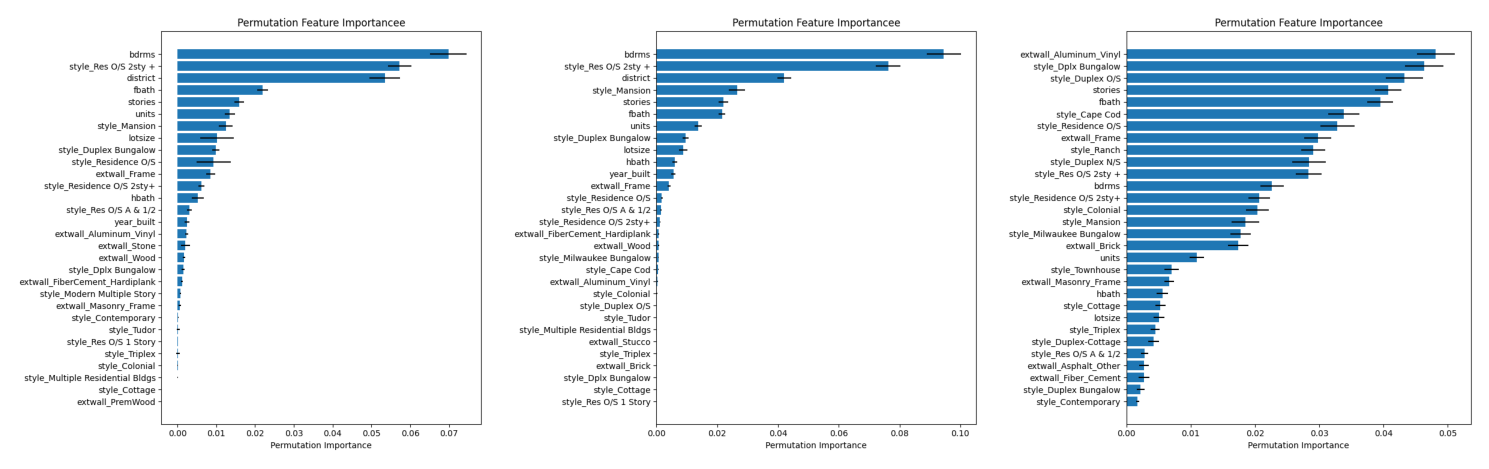

In [23]:
ordner = "../output/"
list_pictures = [datei for datei in os.listdir(ordner) if datei.startswith("pfi_")]
list_pictures = [ordner + n for n in list_pictures]
list_pictures

# Plot mit 1 Zeile und 3 Spalten
fig, axs = plt.subplots(1, len(list_pictures), figsize=(15, 5))  # figsize anpassen

for i, datei in enumerate(list_pictures):
    img = mpimg.imread(datei)
    axs[i].imshow(img)
    axs[i].axis("off")  # Achsen ausblenden

plt.tight_layout()
plt.show()

**PartialDependenceDisplay**

['district' 'stories' 'year_built' 'units' 'bdrms' 'fbath' 'hbath'
 'lotsize' 'style_**' 'style_AP 1' 'style_Bi-Level' 'style_Cape Cod'
 'style_Colonial' 'style_Contemporary' 'style_Cottage'
 'style_Dplx Bungalow' 'style_Duplex Bungalow' 'style_Duplex N/S'
 'style_Duplex O/S' 'style_Duplex-Cottage' 'style_Mansion'
 'style_Milwaukee Bungalow' 'style_Modern Multiple Story'
 'style_Multiple Residential Bldgs' 'style_OBY' 'style_Ranch'
 'style_Res O/S 1 Story' 'style_Res O/S 2sty +' 'style_Res O/S A & 1/2'
 'style_Residence O/S' 'style_Residence O/S 2sty+'
 'style_Rm or Rooming House' 'style_Split Level' 'style_Townhouse'
 'style_Triplex' 'style_Tudor' 'style_Unknown' 'extwall_Alum_VynylSiding'
 'extwall_Aluminum_Vinyl' 'extwall_Asphalt_Other' 'extwall_Block'
 'extwall_Brick' 'extwall_FiberCement_Hardiplank' 'extwall_Fiber_Cement'
 'extwall_Frame' 'extwall_MasonaryFrame' 'extwall_Masonry_Frame'
 'extwall_MetalSiding' 'extwall_PrecastMasonary' 'extwall_PremWood'
 'extwall_Stone' 'extwall_St

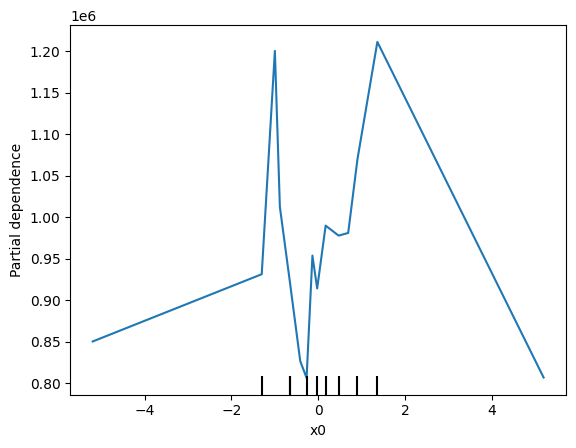

In [21]:
from sklearn.inspection import PartialDependenceDisplay

step_preprocess = RF_Pipe.named_steps["preprocess"]
step_model = RF_Pipe.named_steps["model"]
X_train_transform = step_preprocess.transform(train_data[X])
featureNames = step_preprocess.get_feature_names_out()
feature_names = RF_Pipe[:-1].get_feature_names_out()  # alles außer dem letzten Step (Estimator)
print(feature_names)

PartialDependenceDisplay.from_estimator(step_model, X_train_transform, features=[0])

plt.show()

***
***